# Dropout

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data

data = get_CIFAR10_data()
for k, v in data.items():
    print("%s: " % k, v.shape)

x_test:  (1000, 3, 32, 32)
y_train:  (49000,)
y_val:  (1000,)
x_val:  (1000, 3, 32, 32)
x_train:  (49000, 3, 32, 32)
y_test:  (1000,)


## Dropout forward pass

In [3]:
x = np.random.randn(500, 500) + 10

for p in[0.3, 0.6, 0.75]:
    out, _ = dropout_forward(x, {'mode':'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})
    
    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())

Running tests with p =  0.3
Mean of input:  9.99992630486
Mean of train-time output:  9.96879152229
Mean of test-time output:  9.99992630486
Fraction of train-time output set to zero:  0.700816
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  9.99992630486
Mean of train-time output:  10.0205355282
Mean of test-time output:  9.99992630486
Fraction of train-time output set to zero:  0.398788
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  9.99992630486
Mean of train-time output:  10.0010142294
Mean of test-time output:  9.99992630486
Fraction of train-time output set to zero:  0.249968
Fraction of test-time output set to zero:  0.0


## Dropout backward pass

In [4]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44560625229e-11


## Fully-cennected nets with Dropout

In [5]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
x = np.random.randn(N, D)
y = np.random.randint(C, size = (N, ))

for dropout in [0, 0.25, 0.5]:
    print('Running check with dropout = ', dropout)
    model = FullyConnectedNet([H1, H2], input_dim = D, num_classes = C, weight_scale = 5e-2, 
                             dtype = np.float64, dropout = dropout, seed = 123)
    loss, grads = model.loss(x, y)
    print('Initial loss: ', loss)
    
    for name in sorted(grads):
        f = lambda _: model.loss(x, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose = False, h = 1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with dropout =  0
Initial loss:  2.3051948274
W1 relative error: 2.53e-07
W2 relative error: 1.50e-05
W3 relative error: 2.75e-07
b1 relative error: 2.94e-06
b2 relative error: 5.05e-08
b3 relative error: 1.17e-10
Running check with dropout =  0.25
Initial loss:  2.31264683457
W1 relative error: 1.48e-08
W2 relative error: 2.34e-10
W3 relative error: 3.56e-08
b1 relative error: 1.53e-09
b2 relative error: 1.84e-10
b3 relative error: 8.70e-11
Running check with dropout =  0.5
Initial loss:  2.30243758771
W1 relative error: 4.55e-08
W2 relative error: 2.97e-08
W3 relative error: 4.34e-07
b1 relative error: 1.87e-08
b2 relative error: 5.05e-09
b3 relative error: 7.49e-11


## Regularization experiment

In [6]:
# Train two identical nets, one with dropout and one without.

num_train = 1000
small_data = {
  'x_train': data['x_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'x_val': data['x_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.5]
for dropout in dropout_choices:
    model = FullyConnectedNet([500], dropout = dropout)
    print('Net with dropout = ', dropout)
    
    solver = Solver(model, small_data, num_epochs = 25, batch_size = 100, update_rule = 'adam', 
                   optim_config = {'learning_rate': 1e-4}, verbose = True, print_every = 100)
    solver.train()
    solvers[dropout] = solver

Net with dropout =  0
(Iteration 1 / 250) loss: 8.365677
(Epoch 0 /25) train acc: 0.174000; val_acc: 0.173000
(Epoch 1 /25) train acc: 0.421000; val_acc: 0.291000
(Epoch 2 /25) train acc: 0.538000; val_acc: 0.286000
(Epoch 3 /25) train acc: 0.672000; val_acc: 0.321000
(Epoch 4 /25) train acc: 0.784000; val_acc: 0.298000
(Epoch 5 /25) train acc: 0.832000; val_acc: 0.317000
(Epoch 6 /25) train acc: 0.885000; val_acc: 0.316000
(Epoch 7 /25) train acc: 0.914000; val_acc: 0.345000
(Epoch 8 /25) train acc: 0.951000; val_acc: 0.333000
(Epoch 9 /25) train acc: 0.978000; val_acc: 0.335000
(Epoch 10 /25) train acc: 0.976000; val_acc: 0.336000
(Iteration 101 / 250) loss: 0.054725
(Epoch 11 /25) train acc: 0.997000; val_acc: 0.336000
(Epoch 12 /25) train acc: 0.997000; val_acc: 0.343000
(Epoch 13 /25) train acc: 0.998000; val_acc: 0.326000
(Epoch 14 /25) train acc: 1.000000; val_acc: 0.346000
(Epoch 15 /25) train acc: 0.999000; val_acc: 0.344000
(Epoch 16 /25) train acc: 1.000000; val_acc: 0.34500

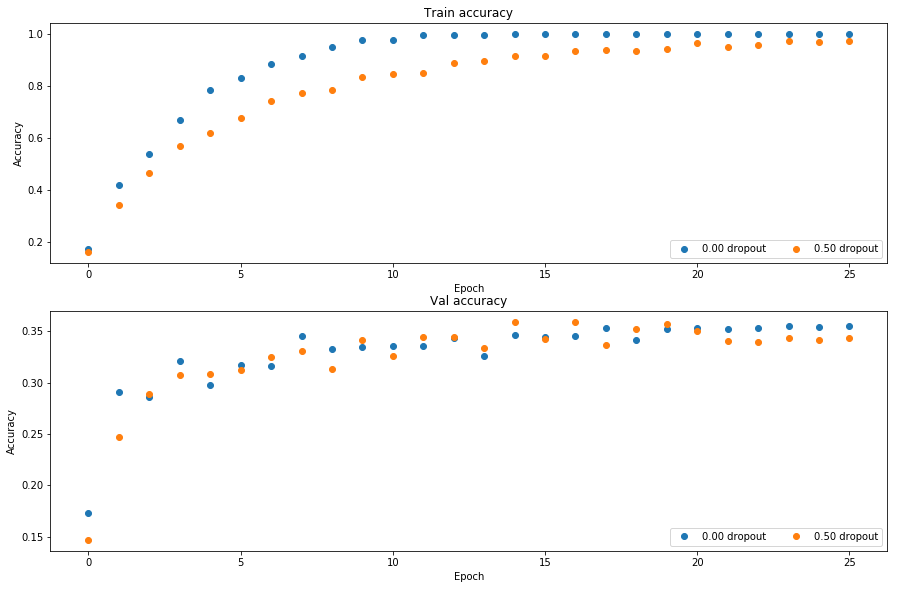

In [7]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
    solver = solvers[dropout]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()